# EMNIST using deep learning
The EMNIST dataset is a set of handwritten character digits derived from the NIST Special Database 19 and converted to a 28x28 pixel image format and dataset structure that directly matches the MNIST dataset. Further information on the dataset contents and conversion process can be found in the paper available at https://arxiv.org/abs/1702.05373v1.

Dataset is available at https://www.kaggle.com/crawford/emnist

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
% matplotlib inline

c:\users\katiohh\anaconda3\envs\ml\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## reading
read data from csv file

In [3]:
train_data_filename = 'EMNIST_data/emnist-balanced-train.csv'
test_data_filename = 'EMNIST_data/emnist-balanced-test.csv'
raw_train_data = pd.read_csv(train_data_filename, header=None).values
raw_test_data = pd.read_csv(test_data_filename, header=None).values

read mapping file

In [4]:
mapping_filename = 'EMNIST_data/emnist-balanced-mapping.txt'
mapper = {}
with open(mapping_filename) as f:
    m = map(str.split, f.readlines())
    for item in m:
        mapper.update({int(item[0]): chr(int(item[1]))})
print(mapper)

{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J', 20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T', 30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z', 36: 'a', 37: 'b', 38: 'd', 39: 'e', 40: 'f', 41: 'g', 42: 'h', 43: 'n', 44: 'q', 45: 'r', 46: 't'}


## loading
load data into numpy

In [5]:
classes = 47
eye = np.eye(classes)
train_images, train_labels = raw_train_data[:, 1:].astype(np.float32), eye[raw_train_data[:, :1].ravel()]
test_images, test_labels = raw_test_data[:, 1:].astype(np.float32), eye[raw_test_data[:, :1].ravel()]
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(112800, 784)
(112800, 47)
(18800, 784)
(18800, 47)


## data visiualization

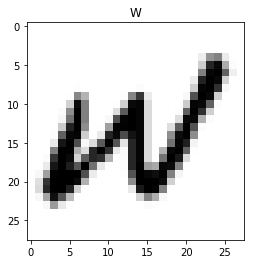

In [6]:
index = 69
img = train_images[index].reshape(28, 28).T
plt.imshow(img, cmap='binary')
plt.title(mapper[np.argmax(train_labels[index])])
plt.show()

data normalization

In [7]:
train_images /= 255.0
test_images /= 255.0

## modeling
create a simple linear model classifier

In [32]:
def my_model(inputs, layers, units):
    last = inputs
    for index, layer in enumerate(layers):
        last = tf.layers.dense(inputs=last, units=layer, activation=tf.nn.relu)
        last = tf.layers.dropout(last)
    y = tf.layers.dense(inputs=last, units=units)
    return y

In [33]:
x = tf.placeholder("float", [None, 784])
y = my_model(x, [128, 256, 512, 1024, 1024, 256], classes)
y_hat = tf.nn.softmax(y)

<font color='red'><span class="burk">To ensure numeric stability, standard cross entropy formula should not be used.</span></font>

see also https://stackoverflow.com/questions/33712178/tensorflow-nan-bug

In [34]:
y_ = tf.placeholder("float", [None, classes])
cross_entropy = tf.reduce_sum(
    tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=y))
train_step = tf.train.AdamOptimizer().minimize(cross_entropy)

## training
using batch gradient decsent to train the model with 10000 iterations

0 108747.35067367554
1 67653.56498336792
2 58297.13381767273
3 52811.52002334595
4 48405.169956207275
5 44978.251863479614
6 42719.85534000397
7 39960.88708114624
8 38380.12305641174
9 36685.59896183014
10 35159.174359321594
11 33842.35102558136
12 32497.707471847534
13 31538.05770778656
14 30745.543627738953
15 29668.270117759705
16 29628.965392112732
17 28193.131009101868
18 28150.705319404602
19 27834.155862808228


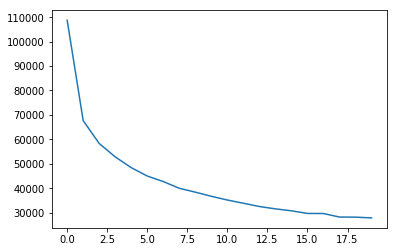

In [35]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()
batch_size = 100
costs = []
for epoch in range(20):
    cost = 0
    p = np.arange(train_images.shape[0])
    np.random.shuffle(p)
    batch_length = np.ceil(train_images.shape[0] / batch_size).astype(int)
    for i in range(batch_length):
        d1 = i * batch_size
        d2 = min(d1 + batch_size, train_images.shape[0])
        d = sess.run([train_step, cross_entropy], feed_dict={
            x: train_images[p[d1: d2]],
            y_: train_labels[p[d1: d2]]
        })
        cost += d[1]
    print(epoch, cost)
    costs.append(cost)
plt.plot(costs)

## evaluating

In [36]:
# print('weight:', b.eval())
correct_prediction = tf.equal(tf.argmax(y_hat, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print('training set accuracy:', sess.run(accuracy, feed_dict={x: train_images, y_: train_labels}))
print('test set accuracy:', sess.run(accuracy, feed_dict={x: test_images, y_: test_labels}))

training set accuracy: 0.91341317
test set accuracy: 0.8406383


## result visiualization

Model predicts N


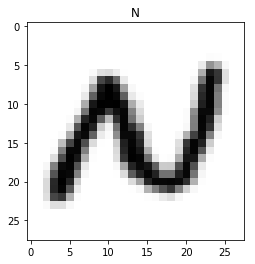

In [27]:
index = 8140
img = test_images[index].reshape(28, 28).T
plt.imshow(img, cmap='binary')
plt.title(mapper[np.argmax(test_labels[index])])
prediction = tf.argmax(y, 1)
print('Model predicts', mapper[prediction.eval(feed_dict={x: test_images[index].reshape(1, 784)})[0]])